## Evaluation

#### Import


In [ ]:
import os
import sys
import glob
import time
import copy
import math
import h5py
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics as metrics

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

from tqdm import tqdm
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

from typing import Callable, Iterable, Optional, Union, List

# from mpl_toolkits.mplot3d import Axes3D     # unused import necessary to have access to 3d projection # noqa: F401
import matplotlib.pyplot as plt

### Shared functions

In [ ]:
OUTPUT_PATH='./output/'

def last_line_file(file):
    try:
        with open(file, "r") as file:
            last_line = (list(file)[-1])
            return last_line
    except:
        return ","

def find_epoch_best_fit(file, column):
    try:
        exec_log = pd.read_csv(file, sep=',')
        return exec_log.loc[exec_log['validation_avg_acc'].idxmax()][column]
    except:
        return ""

def checkpoint_from(model, execution, epoch):
    formated_epoch = '{:04d}'.format(int(epoch) + 1)
    return '{}/{}/ModelNet40/checkpoints/{}/model_{}.t7'.format(OUTPUT_PATH, model, execution, formated_epoch)

def load_executions(model_name):
    #if os.path.isfile('/content/drive/My Drive/tcc/data/{}.csv'.format(model_name)):
    #    executions = pd.read_csv('/content/drive/My Drive/tcc/data/{}.csv'.format(model_name))
    #    executions = executions[(executions.optimizer == 'SGD') | ((executions.optimizer == 'ADAM') & (executions.learning_rate < 0.1))]
    #    return executions

    executions = pd.read_csv('{}/{}/ModelNet40/summary.txt'.format(OUTPUT_PATH,model_name), sep=',')
    executions.drop(executions[executions['execution_id'].str.startswith('#')].index, inplace=True)
    executions['model'] = executions.apply(lambda row: row['model'].replace('DGCNN_ATT', 'AttentionDGCNN'), axis=1)
    executions['loss'] = executions['loss'].astype(float)
    executions['loss'] = executions['loss'].fillna(999999)

    best_epoch = []
    validation_acc = []
    validation_avg_acc = []
    test_acc = []
    test_avg_acc = []
    for index, row in executions.iterrows():
        try:
            exec_log = pd.read_csv('{}/{}/ModelNet40/{}.csv'.format(OUTPUT_PATH,model_name, row['execution_id']), sep=',')
            best = exec_log.loc[exec_log['validation_avg_acc'].idxmax()]

            params=Params(model=row['model'], optimizer=row['optimizer'], lr=row['learning_rate'], att_heads=row['att_heads'], dump_file=False, dry_run=False)
            acc, avg_acc = test(params, state_dict=checkpoint_from(row['model'], row['execution_id'], best['epoch']))
            
            best_epoch.append(best['epoch'])
            validation_acc.append(best['validation_acc'])
            validation_avg_acc.append(best['validation_avg_acc'])
            test_acc.append(acc)
            test_avg_acc.append(avg_acc)
        except:
            best_epoch.append(None)
            validation_acc.append(None)
            validation_avg_acc.append(None)
            test_acc.append(None)
            test_avg_acc.append(None)
        
    executions['best_epoch'] = best_epoch
    executions['validation_acc'] = validation_acc
    executions['validation_avg_acc'] = validation_avg_acc
    executions['test_acc'] = test_acc
    executions['test_avg_acc'] = test_avg_acc

    if model_name in ['PointNet', 'DGCNN']:
        executions['att_heads'] = '-'     

    executions = executions[(executions.optimizer == 'SGD') | ((executions.optimizer == 'ADAM') & (executions.learning_rate < 0.1))]
    executions = executions[executions['validation_avg_acc'] > 0]
    executions = executions[['execution_id', 'model', 'epochs', 'optimizer', 'att_heads', 'learning_rate', 'loss', 'best_epoch', 'validation_acc', 'validation_avg_acc', 'test_acc', 'test_avg_acc']]
    executions = executions.loc[executions.groupby(['model', 'optimizer', 'att_heads', 'learning_rate'])['test_avg_acc'].idxmax()]  
    
    executions.sort_values(['model', 'optimizer', 'att_heads', 'learning_rate'], inplace=True)

    #executions.to_csv('/content/drive/My Drive/tcc/data/{}.csv'.format(model_name), index=False)
    return executions

def plot_accuracy_loss(model_name, executions, title=None):
    fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(17,10))
    if title == None:
        fig.suptitle(model_name, fontsize=16)
    else:
        fig.suptitle(title, fontsize=16)
    
    ax1[0].title.set_text('Accuracy')
    ax1[1].title.set_text('Loss')
    ax1[1].set_ylim(0,10)
    ax2[0].title.set_text('Accuracy')
    ax2[1].title.set_text('Loss')
    ax2[1].set_ylim(0,10)

    for _, execution in executions.iterrows():
        csv_exec = '{}/{}/ModelNet40/{}.csv'.format(OUTPUT_PATH, model_name, execution['execution_id'])
        if os.path.isfile(csv_exec):
            df = pd.read_csv(csv_exec, sep=',')
            ax_acc = ax1[0] if execution['optimizer'] == 'ADAM' else ax2[0]
            ax_loss = ax1[1] if execution['optimizer'] == 'ADAM' else ax2[1]

            df['validation_loss'] = df['validation_loss'].astype(float)
            df['validation_loss'] = df['validation_loss'].fillna(999999)
            df['validation_loss'] =  np.where((df.validation_loss > 10),10,df.validation_loss)
            df['validation_avg_acc'].plot(ax=ax_acc, legend=True, label='{}-{}'.format(execution['optimizer'], execution['learning_rate']))
            df['validation_loss'].plot(ax=ax_loss, legend=True, label='{}-{}'.format(execution['optimizer'], execution['learning_rate']), logy=False)
    plt.show()
 
def best_test_accuracy(executions):
    df = executions[['execution_id', 'optimizer', 'learning_rate', 'loss', 'validation_acc', 'validation_avg_acc', 'test_acc', 'test_avg_acc']]
    return df.loc[df.groupby('optimizer')['test_avg_acc'].idxmax()]    

### PointNet x PointAttentionNet

#### PointNet

In [ ]:
pointnet_executions = load_executions('PointNet')
pointnet_executions.sample(5)

,execution_id,model,epochs,optimizer,att_heads,learning_rate,loss,best_epoch,validation_acc,validation_avg_acc,test_acc,test_avg_acc
0,execution_0001,PointNet,300,ADAM,-,0.00001,1.579543,287.0,0.886241,0.817149,0.900379,0.851438
6,execution_0008,PointNet,300,SGD,-,0.02500,1.585680,187.0,0.895450,0.843008,0.905793,0.864746
5,execution_0007,PointNet,300,SGD,-,0.01250,1.588114,232.0,0.902492,0.849871,0.911207,0.868523
1,execution_0002,PointNet,300,ADAM,-,0.00010,1.538730,291.0,0.900325,0.849884,0.927450,0.891816
2,execution_0003,PointNet,300,ADAM,-,0.00100,1.606209,284.0,0.885699,0.827213,0.905252,0.863722


In [ ]:
best_test_accuracy(pointnet_executions)

,execution_id,optimizer,learning_rate,loss,validation_acc,validation_avg_acc,test_acc,test_avg_acc
1,execution_0002,ADAM,0.0001,1.538730,0.900325,0.849884,0.927450,0.891816
5,execution_0007,SGD,0.0125,1.588114,0.902492,0.849871,0.911207,0.868523


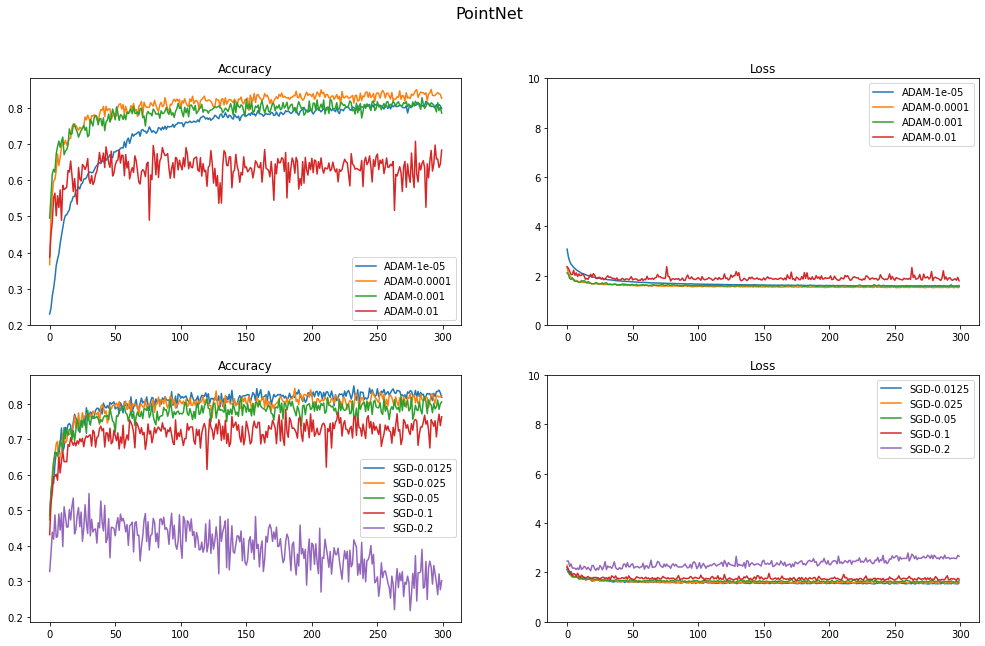

In [ ]:
plot_accuracy_loss('PointNet', pointnet_executions)

#### PointAttentionNet

In [ ]:
pointattentionnet_executions = load_executions('PointAttentionNet')
pointattentionnet_executions.sample(5)

,execution_id,model,epochs,optimizer,att_heads,learning_rate,loss,best_epoch,validation_acc,validation_avg_acc,test_acc,test_avg_acc
22,execution_0032,PointAttentionNet,300,SGD,4,0.2000,999999.000000,0.0,0.061213,0.025000,0.057390,0.025000
18,execution_0028,PointAttentionNet,300,SGD,4,0.0125,1.602870,228.0,0.885699,0.831995,0.903628,0.856941
3,execution_0010,PointAttentionNet,300,ADAM,8,0.0100,3.552540,2.0,0.027086,0.033800,0.019491,0.023607
20,execution_0030,PointAttentionNet,300,SGD,4,0.0500,1.692004,206.0,0.877573,0.816537,0.888468,0.837230
2,execution_0009,PointAttentionNet,300,ADAM,8,0.0010,1.580084,238.0,0.881907,0.829844,0.899838,0.858170


In [ ]:
best_test_accuracy(pointattentionnet_executions[pointattentionnet_executions['att_heads'] == 4])

,execution_id,optimizer,learning_rate,loss,validation_acc,validation_avg_acc,test_acc,test_avg_acc
9,execution_0018,ADAM,0.0001,1.561611,0.904117,0.848771,0.92745,0.889303
19,execution_0029,SGD,0.0250,1.613522,0.878657,0.825771,0.90471,0.858028


In [ ]:
best_test_accuracy(pointattentionnet_executions[pointattentionnet_executions['att_heads'] == 8])

,execution_id,optimizer,learning_rate,loss,validation_acc,validation_avg_acc,test_acc,test_avg_acc
1,execution_0008,ADAM,0.0001,1.543298,0.895991,0.847024,0.916622,0.882440
13,execution_0022,SGD,0.0125,1.606425,0.894366,0.839947,0.917704,0.881894


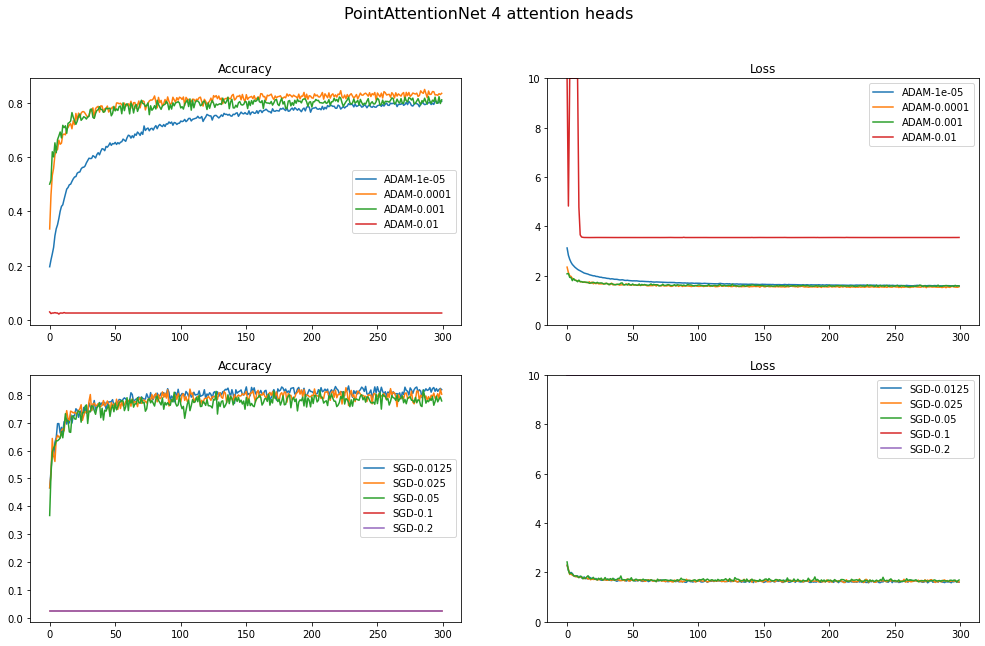

In [ ]:
plot_accuracy_loss('PointAttentionNet', pointattentionnet_executions[pointattentionnet_executions['att_heads'] == 4], title='PointAttentionNet 4 attention heads')

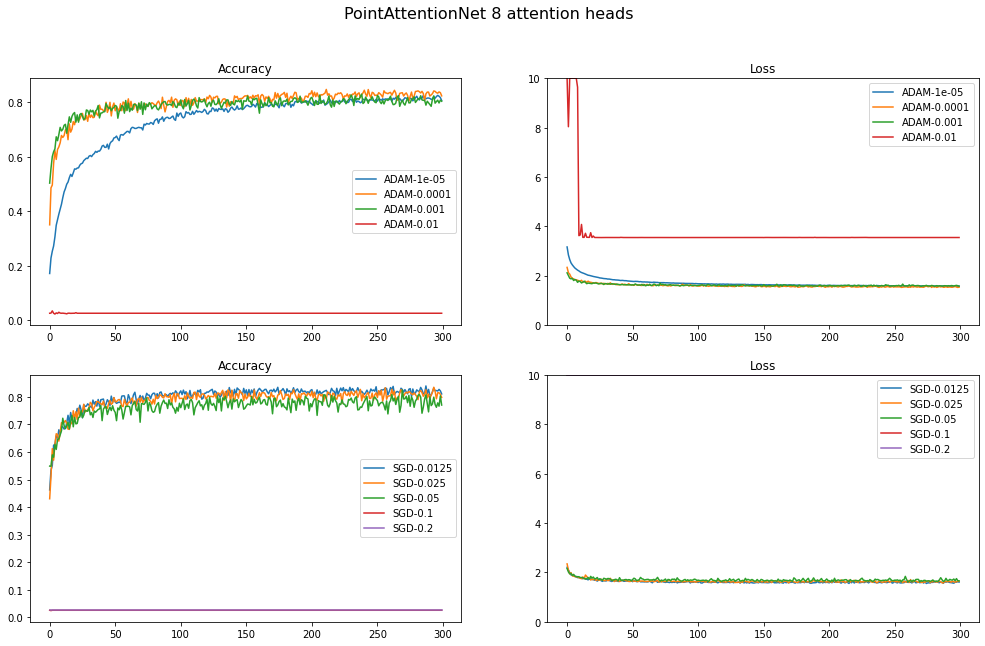

In [ ]:
plot_accuracy_loss('PointAttentionNet', pointattentionnet_executions[pointattentionnet_executions['att_heads'] == 8], title='PointAttentionNet 8 attention heads')

### DGCNN x AttentionDGCNN

#### DGCNN

In [ ]:
dgcnn_executions = load_executions('DGCNN')
dgcnn_executions.sample(5)

,execution_id,model,epochs,optimizer,att_heads,learning_rate,loss,best_epoch,validation_acc,validation_avg_acc,test_acc,test_avg_acc
0,execution_0001,DGCNN,150,ADAM,-,0.00001,1.537878,133.0,0.903034,0.855880,0.926909,0.888415
3,execution_0004,DGCNN,150,ADAM,-,0.01000,1.758917,128.0,0.859155,0.788602,0.871142,0.802415
1,execution_0002,DGCNN,150,ADAM,-,0.00010,1.455644,113.0,0.919285,0.890441,0.959394,0.941224
9,execution_0011,DGCNN,150,SGD,-,0.20000,1.644414,141.0,0.905742,0.857027,0.914997,0.875434
8,execution_0010,DGCNN,150,SGD,-,0.10000,1.491947,115.0,0.913326,0.885530,0.924743,0.898131


In [ ]:
best_test_accuracy(dgcnn_executions)

,execution_id,optimizer,learning_rate,loss,validation_acc,validation_avg_acc,test_acc,test_avg_acc
1,execution_0002,ADAM,0.0001,1.455644,0.919285,0.890441,0.959394,0.941224
6,execution_0007,SGD,0.0250,1.452832,0.933369,0.903878,0.957769,0.941677


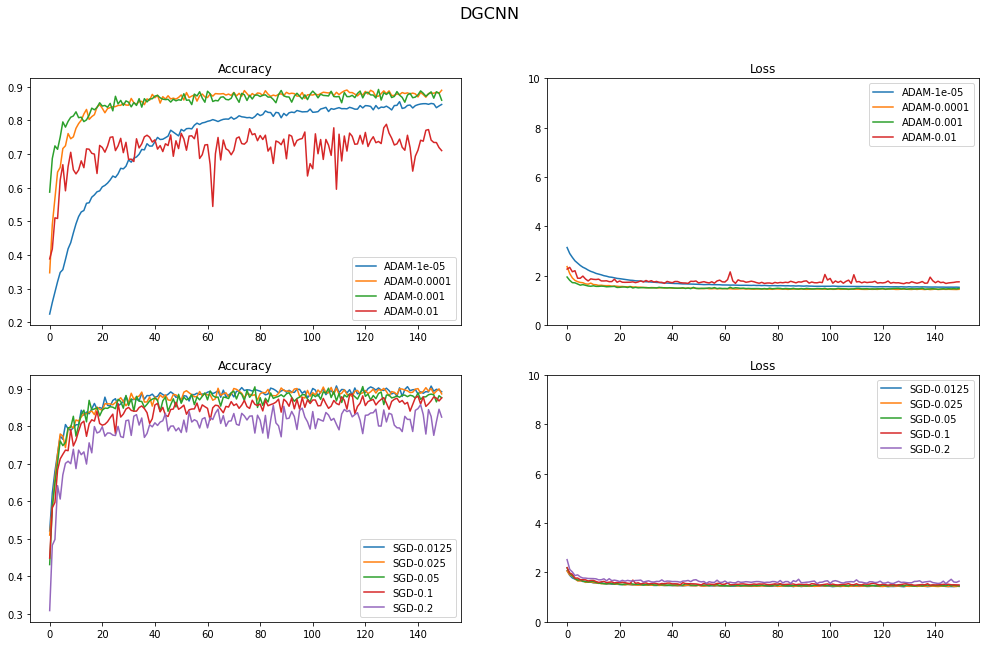

In [ ]:
plot_accuracy_loss('DGCNN', dgcnn_executions)

#### AttentionDGCNN

In [ ]:
attention_dgcnn_executions = load_executions('AttentionDGCNN')
attention_dgcnn_executions.sample(5)

,execution_id,model,epochs,optimizer,att_heads,learning_rate,loss,best_epoch,validation_acc,validation_avg_acc,test_acc,test_avg_acc
16,execution_0021,AttentionDGCNN,150,SGD,4,0.01250,1.428789,115.0,0.934453,0.909264,0.961018,0.944779
19,execution_0025,AttentionDGCNN,150,SGD,4,0.10000,1.506227,143.0,0.920910,0.878967,0.937195,0.904034
0,execution_0001,AttentionDGCNN,150,ADAM,8,0.00001,1.533883,146.0,0.913868,0.866288,0.926367,0.884357
18,execution_0024,AttentionDGCNN,150,SGD,4,0.05000,1.459771,111.0,0.929036,0.896838,0.940985,0.917641
17,execution_0023,AttentionDGCNN,150,SGD,4,0.02500,1.430568,148.0,0.926869,0.903916,0.954521,0.940098


In [ ]:
best_test_accuracy(attention_dgcnn_executions[attention_dgcnn_executions['att_heads'] == 4])

,execution_id,optimizer,learning_rate,loss,validation_acc,validation_avg_acc,test_acc,test_avg_acc
6,execution_0008,ADAM,0.0001,1.442805,0.932828,0.909315,0.949648,0.930352
16,execution_0021,SGD,0.0125,1.428789,0.934453,0.909264,0.961018,0.944779


In [ ]:
best_test_accuracy(attention_dgcnn_executions[attention_dgcnn_executions['att_heads'] == 8])

,execution_id,optimizer,learning_rate,loss,validation_acc,validation_avg_acc,test_acc,test_avg_acc
1,execution_0002,ADAM,0.0001,1.436820,0.930119,0.905203,0.950731,0.927728
10,execution_0014,SGD,0.0125,1.443293,0.935536,0.908405,0.957769,0.941428


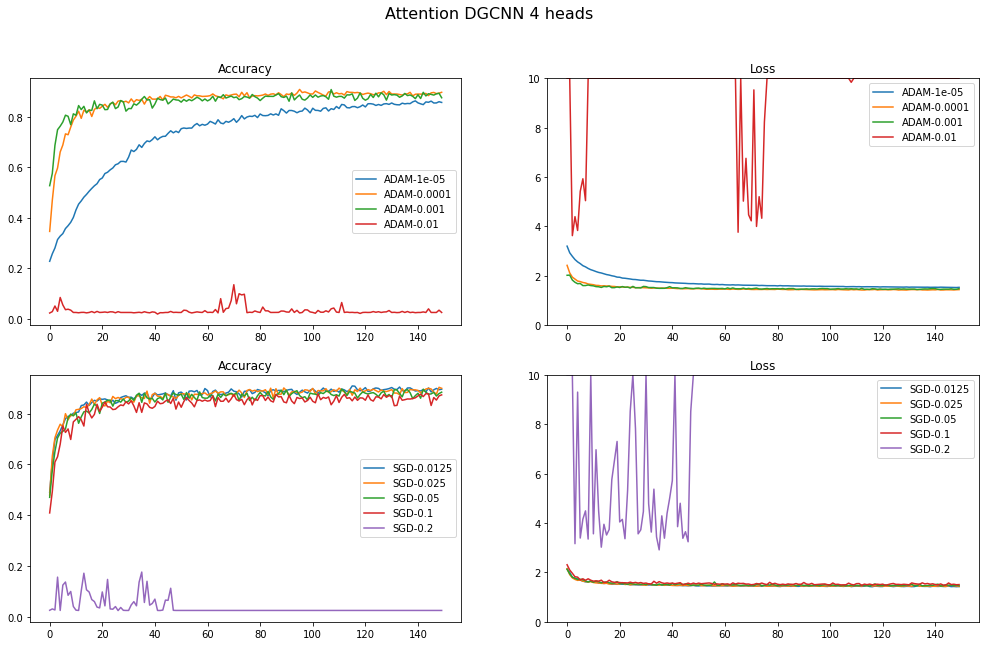

In [ ]:
plot_accuracy_loss('AttentionDGCNN', attention_dgcnn_executions[attention_dgcnn_executions['att_heads'] == 4], title='Attention DGCNN 4 heads')

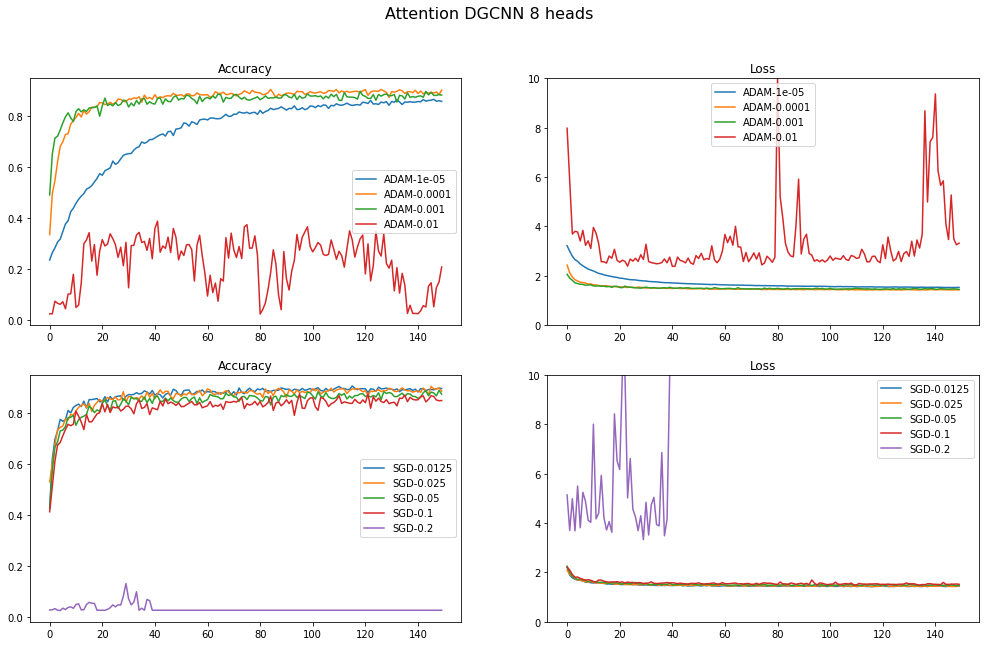

In [ ]:
plot_accuracy_loss('AttentionDGCNN', attention_dgcnn_executions[attention_dgcnn_executions['att_heads'] == 8], title='Attention DGCNN 8 heads')

### Results

#### Best hyperparameters

In [ ]:
def table_results(executions):
    best = []
    for df in executions:
        best.append(df.loc[df.index == df['test_avg_acc'].idxmax()])

    return pd.concat(best)

results = table_results([pointnet_executions, pointattentionnet_executions, dgcnn_executions, attention_dgcnn_executions ])
results[['model', 'optimizer', 'att_heads', 'learning_rate', 'validation_avg_acc', 'test_avg_acc']]

,model,optimizer,att_heads,learning_rate,validation_avg_acc,test_avg_acc
1,PointNet,ADAM,-,0.0001,0.849884,0.891816
9,PointAttentionNet,ADAM,4,0.0001,0.848771,0.889303
6,DGCNN,SGD,-,0.0250,0.903878,0.941677
16,AttentionDGCNN,SGD,4,0.0125,0.909264,0.944779


#### Original vs Attention


In [ ]:
def plot_execution_comparism(ax, executions, column, logy=False):
 for _, execution in executions.iterrows():
        csv_exec = '{}/{}/ModelNet40/{}.csv'.format(OUTPUT_PATH, execution['model'], execution['execution_id'])
        if os.path.isfile(csv_exec):
            df = pd.read_csv(csv_exec, sep=',')
            df[column].plot(ax=ax, legend=True, label='{}-{}'.format(execution['optimizer'], execution['learning_rate']), logy=logy)

def plot_comparism(title, pointnet, pointattentionnet, dgcnn, attention_dgcnn, attribute, logy=False):
    fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(14,8))
    fig.suptitle(title, fontsize=16)
        
    ax1[0].title.set_text("PointNet")
    ax1[1].title.set_text("PointAttentionNet")
    ax2[0].title.set_text("DGCNN")
    ax2[1].title.set_text("AttentionDGCNN")

    plot_execution_comparism(ax1[0], pointnet, attribute, logy=logy)
    plot_execution_comparism(ax1[1], pointattentionnet, attribute, logy=logy)

    plot_execution_comparism(ax2[0], dgcnn, attribute, logy=logy)
    plot_execution_comparism(ax2[1], attention_dgcnn, attribute, logy=logy)

    plt.show()


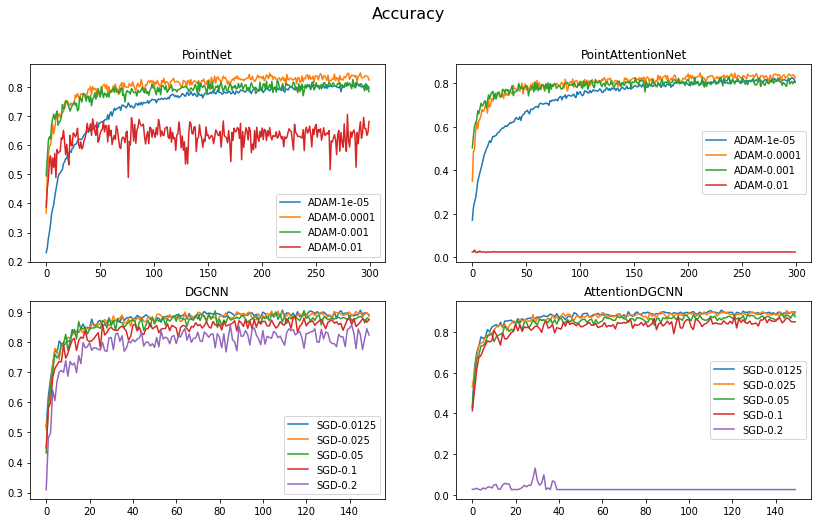

In [ ]:
plot_comparism(
    'Accuracy',
    pointnet_executions[pointnet_executions['optimizer'] == 'ADAM'],
    pointattentionnet_executions[(pointattentionnet_executions.optimizer == 'ADAM') & (pointattentionnet_executions.att_heads == 8)],
    dgcnn_executions[dgcnn_executions['optimizer'] == 'SGD'],
    attention_dgcnn_executions[(attention_dgcnn_executions.optimizer == 'SGD') & (attention_dgcnn_executions.att_heads == 8)],
    'validation_avg_acc'
)

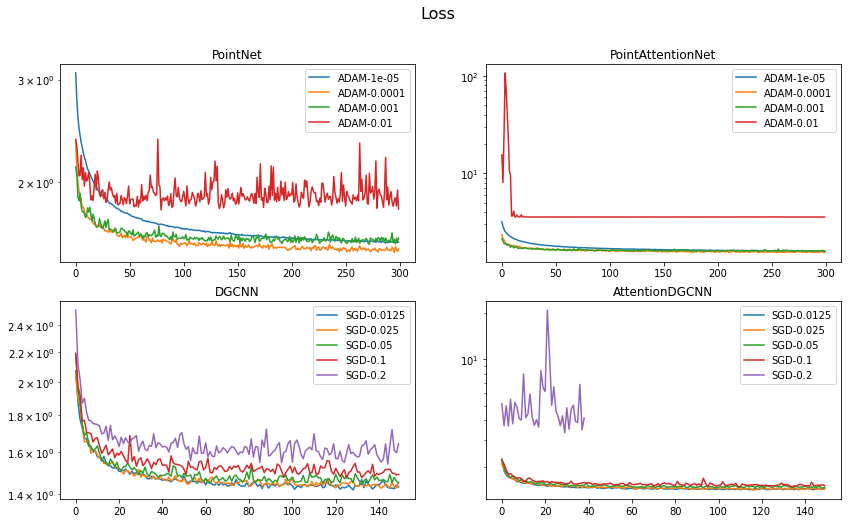

In [ ]:
plot_comparism(
    'Loss',
    pointnet_executions[pointnet_executions['optimizer'] == 'ADAM'],
    pointattentionnet_executions[(pointattentionnet_executions.optimizer == 'ADAM') & (pointattentionnet_executions.att_heads == 8)],
    dgcnn_executions[dgcnn_executions['optimizer'] == 'SGD'],
    attention_dgcnn_executions[(attention_dgcnn_executions.optimizer == 'SGD') & (attention_dgcnn_executions.att_heads == 8)],
    'validation_loss',
    logy=True
)

#### Qualitative analisis

In [ ]:
from mpl_toolkits.mplot3d import Axes3D     # unused import necessary to have access to 3d projection # noqa: F401
import matplotlib.pyplot as plt

def visualize_batch(title, pointclouds, pred_labels, labels, label_description):
    batch_size = len(pointclouds)
    fig = plt.figure(figsize=(8, batch_size / 2))
    
    fig.suptitle(title, fontsize=16)
    
    ncols = 4
    nrows = max(1, batch_size // 4)
    for idx, pc in enumerate(pointclouds):
        label = label_description[labels[idx].item()]
        pred = label_description[pred_labels[idx]]
        colour = 'g' if label == pred else 'r'
        pc = pc.cpu().numpy()
        ax = fig.add_subplot(nrows, ncols, idx + 1, projection='3d')
        ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=colour, s=0.5)
        ax.axis('off')
        ax.set_title('GT: {0}\nPred: {1}'.format(label, pred))

    plt.show()


def plot_test(model_name, optimizer, execution_id, lr, att_heads, dataset):
    params=Params(model=model_name, optimizer=optimizer, lr=lr, att_heads=att_heads, dump_file=False, dry_run=False)
    last_checkpoint = [f for f in glob.glob('{}/{}/ModelNet40/checkpoints/{}/*.t7'.format(OUTPUT_PATH, model_name, execution_id))][-1]

    test_loader = DataLoader(dataset, batch_size=16, shuffle=False)

    model = select_model(params)
    model = nn.DataParallel(model)
    model.load_state_dict(torch.load(last_checkpoint))

    with torch.no_grad():
        data_raw, label_raw = next(iter(test_loader))
        data, label = data_raw.to(params.device), label_raw.to(params.device).squeeze()
        data = data.permute(0, 2, 1)
        batch_size = data.size()[0]
        logits = model(data)
        preds = logits.max(dim=1)[1]
        test_acc = metrics.accuracy_score(label.cpu().numpy(), preds.detach().cpu().numpy())
        visualize_batch("{} (Heads={})".format(model_name, att_heads), data_raw, preds, label, dataset.label_description)

    

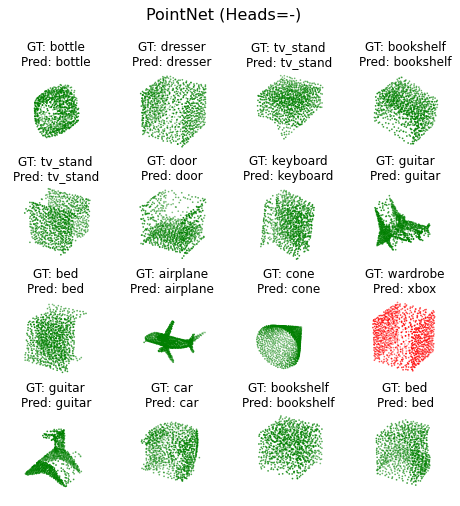

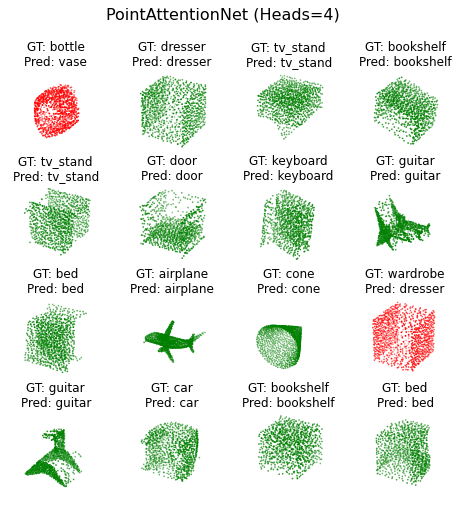

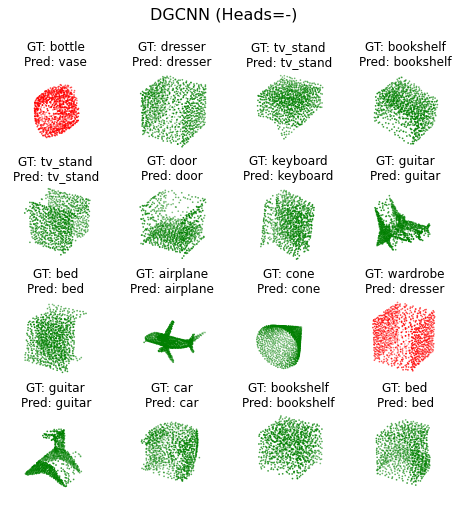

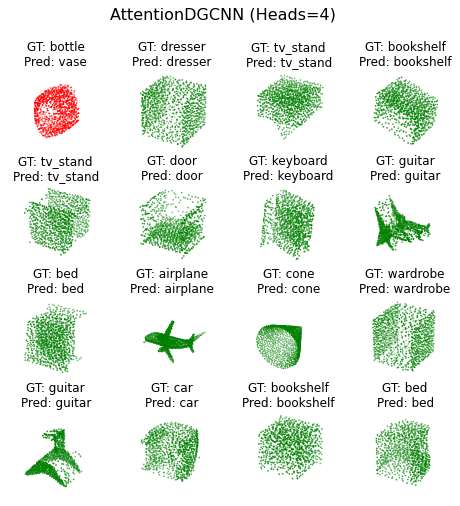

In [ ]:
dataset = ModelNet40(partition='test', num_points=1024, random_state=42)
for _, row in results.iterrows():
    rd = row.to_dict() 
    plot_test(rd['model'], rd['optimizer'], rd['execution_id'], rd['learning_rate'], rd['att_heads'], dataset)


In [ ]:
for i in range(10):
    all_executions = pd.concat([
                                load_executions('PointNet'), 
                                load_executions('PointAttentionNet'), 
                                load_executions('DGCNN'), 
                                load_executions('AttentionDGCNN')
                            ])
    all_executions.to_csv('/content/{}-{}.csv'.format('all_executions', i), index=False)
    print(i)



0
1
2
3
4
5
6
7
8
9
